<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install scikit-learn==1.2.2

In [2]:
# загружаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)

from sklearn.model_selection import (
    GridSearchCV,
    train_test_split
)

import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor

import torch
import torch.nn as nn

import math
from sklearn.preprocessing import StandardScaler

In [3]:
# грузим данные
try:
    data=pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
    data_for_lr = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    data=pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    data_for_lr = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])


In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Вывод:** В загруженном датасете 26496 строчек, в основном с разбивкой по 10 минут. В дальнейшем датасет сильно сократится при ресемпле по 1 часу.

## Анализ

In [6]:
# подготовка данных для изучения согласно поставленной задаче

# сохраним на всякий случай оригинальные данные
data_orig = data.copy()

data = data.resample('1D').sum()

data_1_с = data_orig.copy()
data_1_с = data_1_с.resample('1H').sum()

data_2_с = data_orig.copy()
data_2_с = data_2_с.resample('1W').sum()


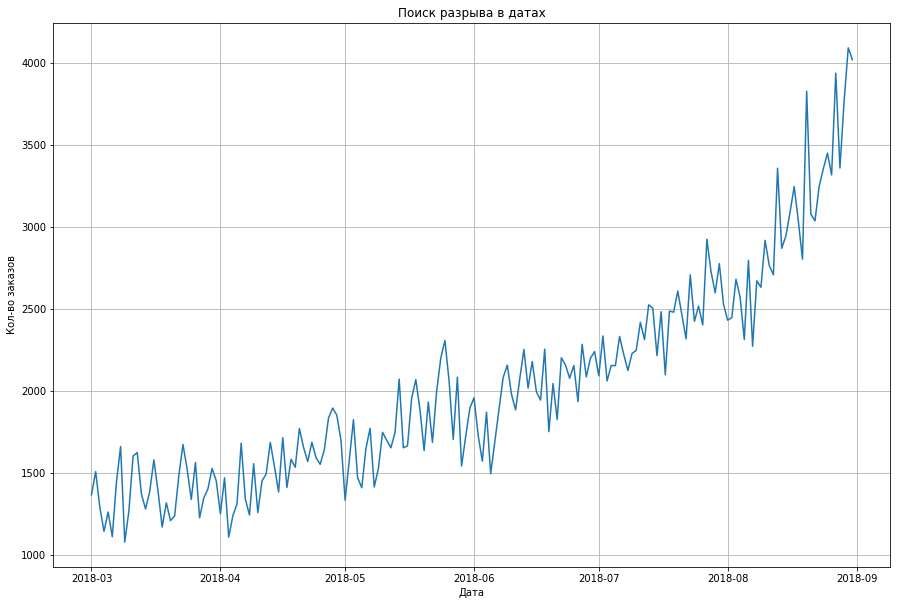

In [7]:
# посмотрим на динамику данных и есть ли разрывы в данных

plt.figure(figsize=(15,10))
plt.plot(data)
plt.grid(True)
plt.title('Поиск разрыва в датах')
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.show()


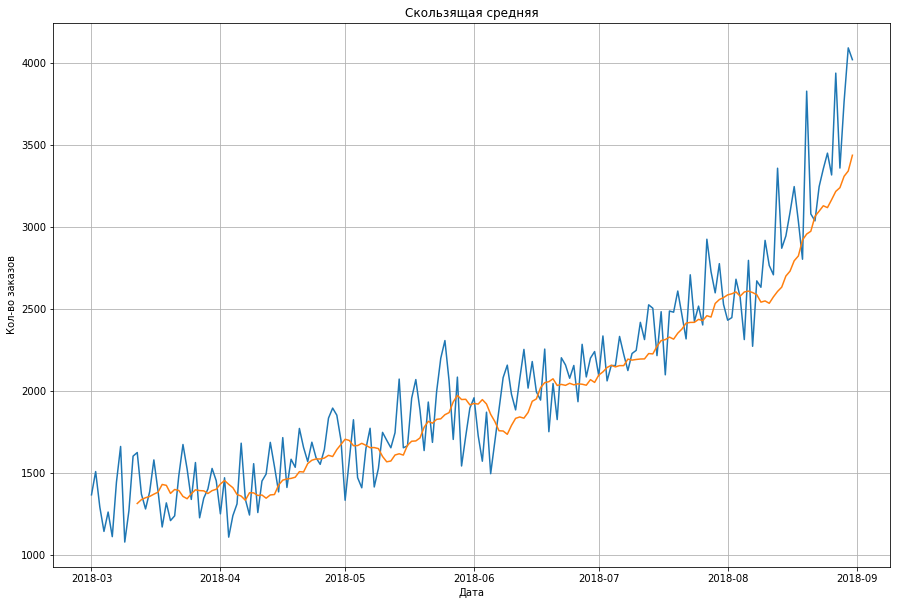

In [8]:
# построим скользящую среднюю по всем данным

data['rolling_mean'] = data.shift().rolling(10, closed = 'left').mean()

plt.figure(figsize=(15,10))
plt.plot(data)
plt.grid(True)
plt.title('Скользящая средняя')
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.show()


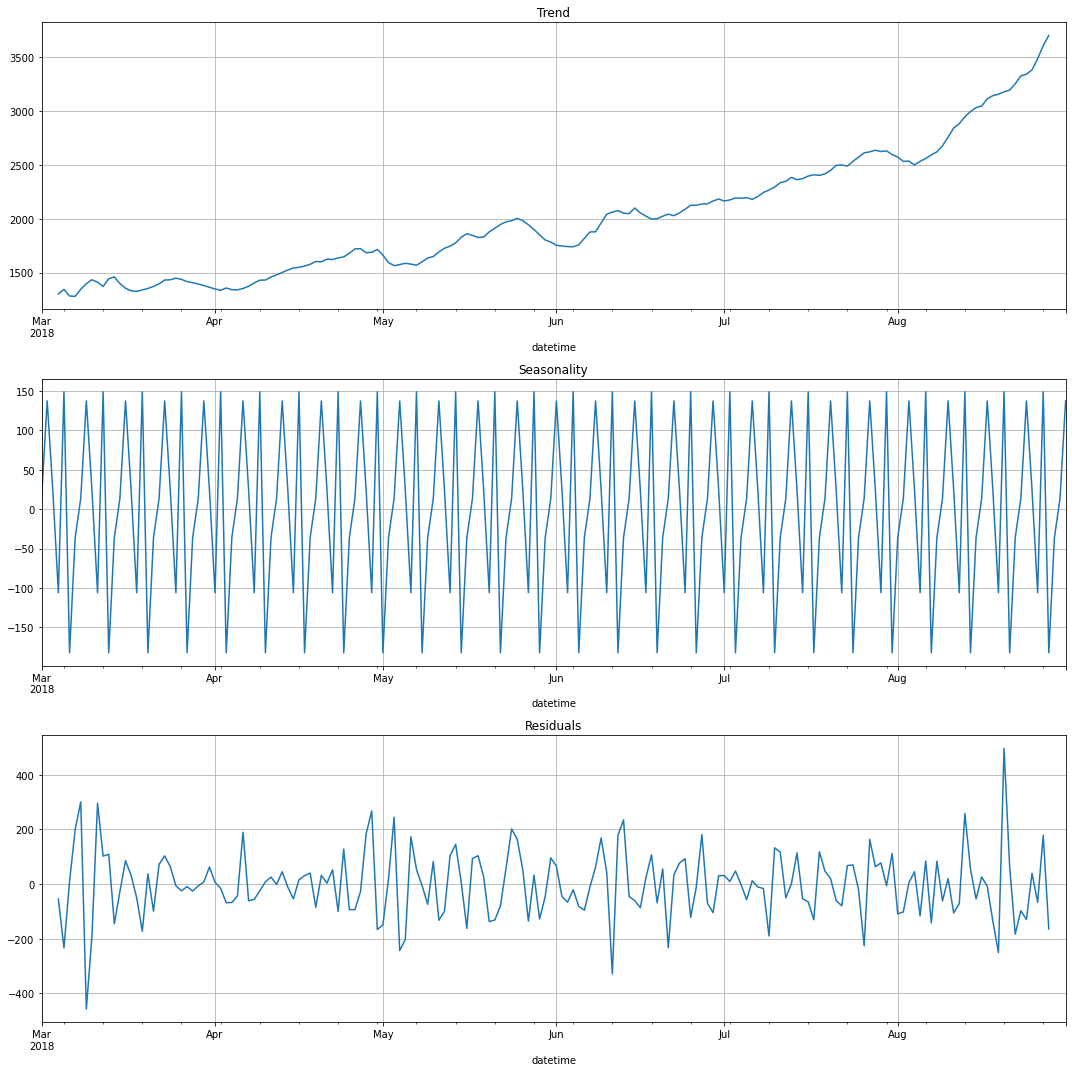

In [9]:
# посмотрим декомпозицию по сезонам, трендам и остаткам по всем данным

decomposed = seasonal_decompose(data['num_orders']) 

plt.figure(figsize=(15,15))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.grid(True)
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.grid(True)
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.grid(True)
plt.title('Residuals')

plt.tight_layout()



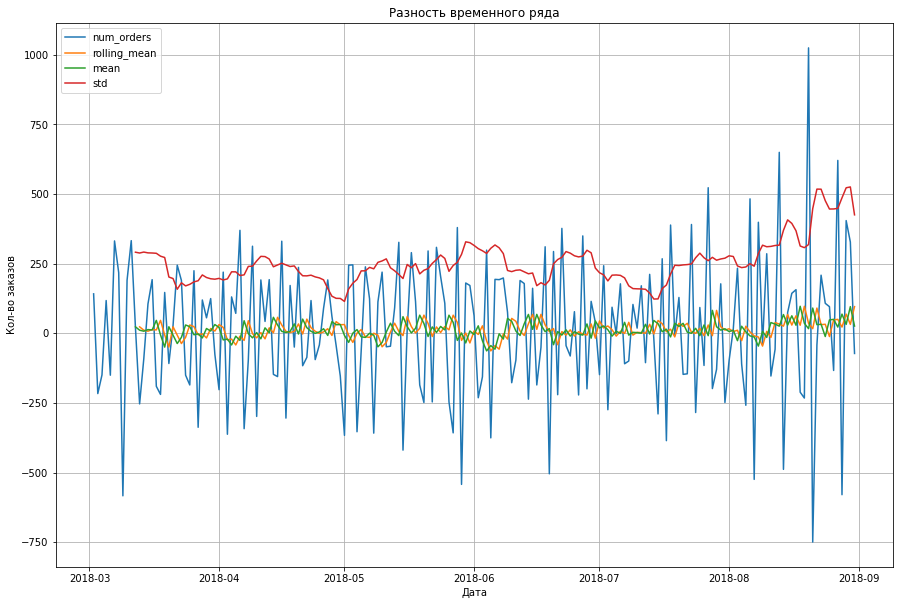

In [10]:
# Посмотрим на разность временного ряда по всем данным
data_copy = data.copy()
data_copy = data_copy - data_copy.shift()

data_copy['mean'] = data_copy['num_orders'].shift().rolling(10).mean()
data_copy['std'] = data_copy['num_orders'].shift().rolling(10).std()

plt.figure(figsize=(15,10))

plt.plot(data_copy)
plt.legend(data_copy)
plt.grid(True)
plt.title('Разность временного ряда')
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.show()


plt.show()

del data_copy

**Вывод:** Разность временного ряда не семитрична, видно, что в августе идет сильнейшие колебания разности, в будущем это может привести к возможному ухудшению метрики т.к. в обучающей выборке отсутствуют примеры таких колебаний.

/tmp/ipykernel_107/965681512.py:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(data['2018-08'])


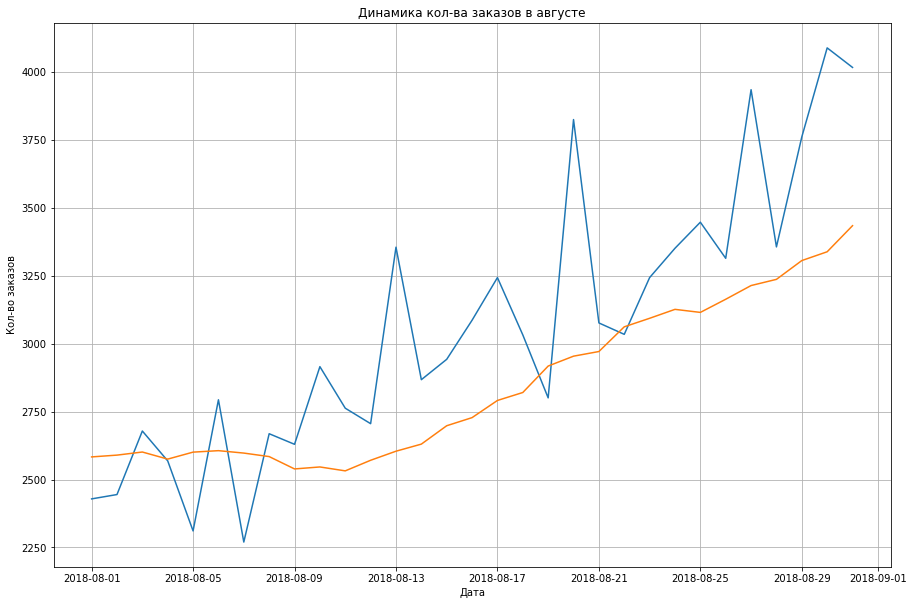

In [11]:
# Исследование динамики роста заказов в августе

plt.figure(figsize=(15,10))
plt.plot(data['2018-08'])
plt.grid(True)
plt.title('Динамика кол-ва заказов в августе')
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.show()


**Вывод:** Линия заказов такси в августе имеет заметный ломанный видн, возможно это проявление сезонности по дням неделям.

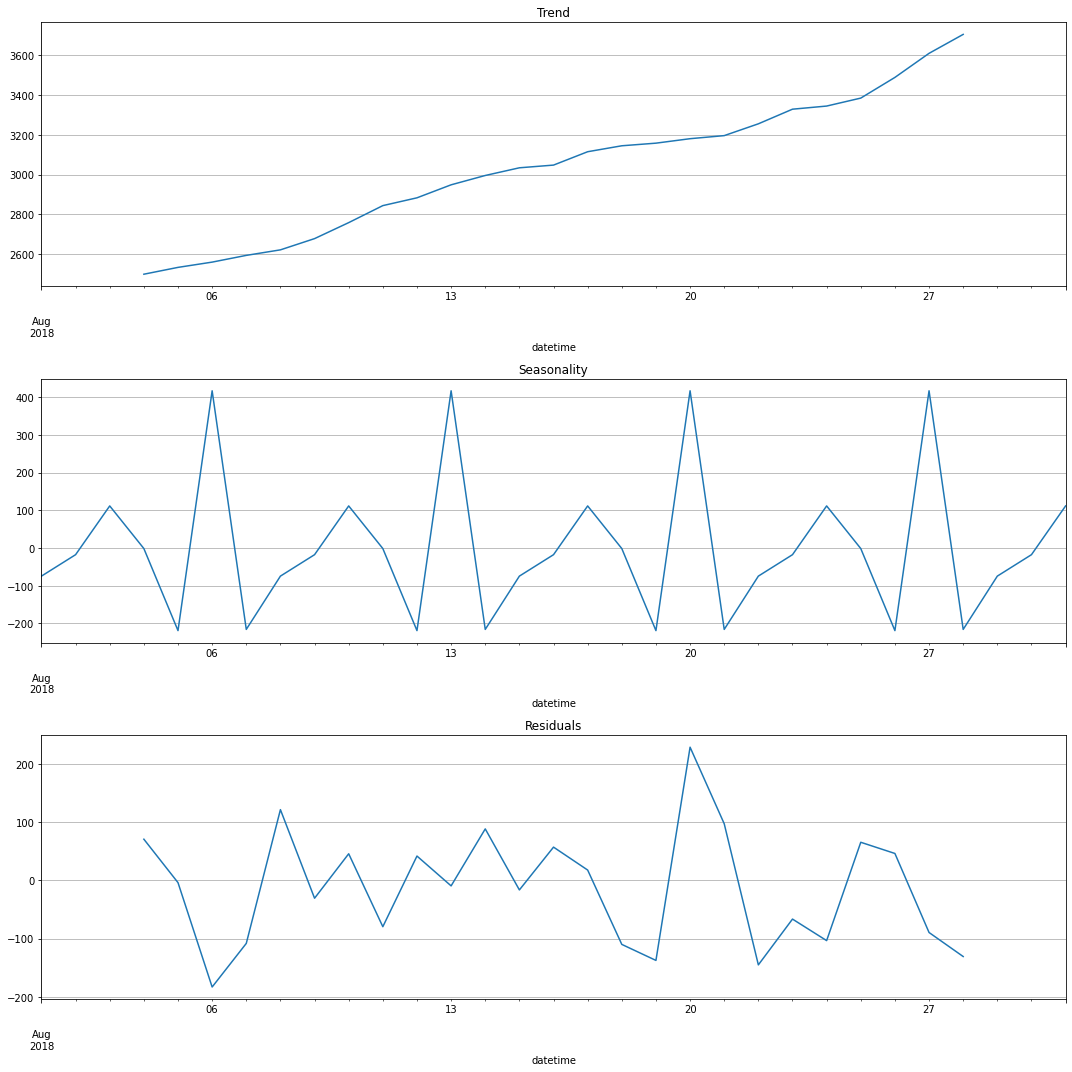

In [12]:
# посмотрим декомпозицию по сезонам, трендам и остаткам для августа

decomposed = seasonal_decompose(data['num_orders']['2018-08']) 

plt.figure(figsize=(15,15))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.grid(True)
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.grid(True)
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.grid(True)
plt.title('Residuals')

plt.tight_layout()


**Вывод:** Сезонность по дням в августе прослеживается чётко, 6, 13, 20 и 27 число в 2018 году это понедельники. В эти дни всегда происходили пики по заказам.

/tmp/ipykernel_107/1865323212.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  avg_h = pd.DataFrame({'num_orders': data_1_с['2018-08-01']['num_orders']})
/tmp/ipykernel_107/1865323212.py:9: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  time_one_day = data_1_с[st]['num_orders']


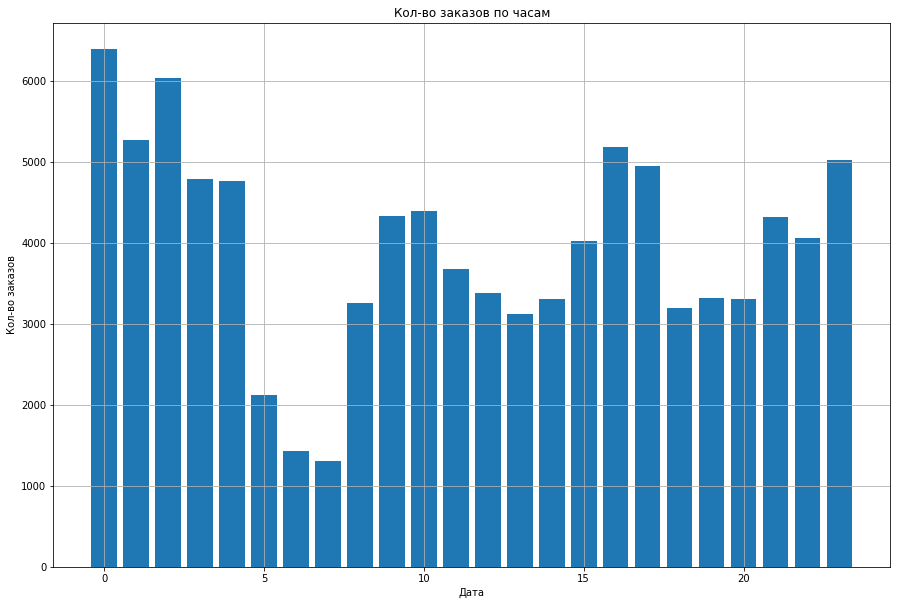

In [13]:
# Посмотрим на рост значений по часам в августе.

avg_h = pd.DataFrame({'num_orders': data_1_с['2018-08-01']['num_orders']})
avg_h = avg_h.reset_index()
avg_h = avg_h.drop('datetime', axis = 1)

for i in range(2,32):
    st = f'2018-08-{i}'
    time_one_day = data_1_с[st]['num_orders']
    time_one_day = time_one_day.reset_index()
    time_one_day = time_one_day.drop('datetime', axis = 1)
    
    avg_h['num_orders'] = avg_h['num_orders'] + time_one_day['num_orders']
    
plt.figure(figsize=(15,10))
plt.bar(x = [x for x in range(len(avg_h))], height = avg_h['num_orders'])
plt.grid(True)
plt.title('Кол-во заказов по часам')
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.show()

**Вывод:** В самом нагруженном месяце видно, что самые не популярные для заказов такси часы это 5, 6 и 7 часов утра. Самые популярные это с 1 часа ночи до 3 часов.

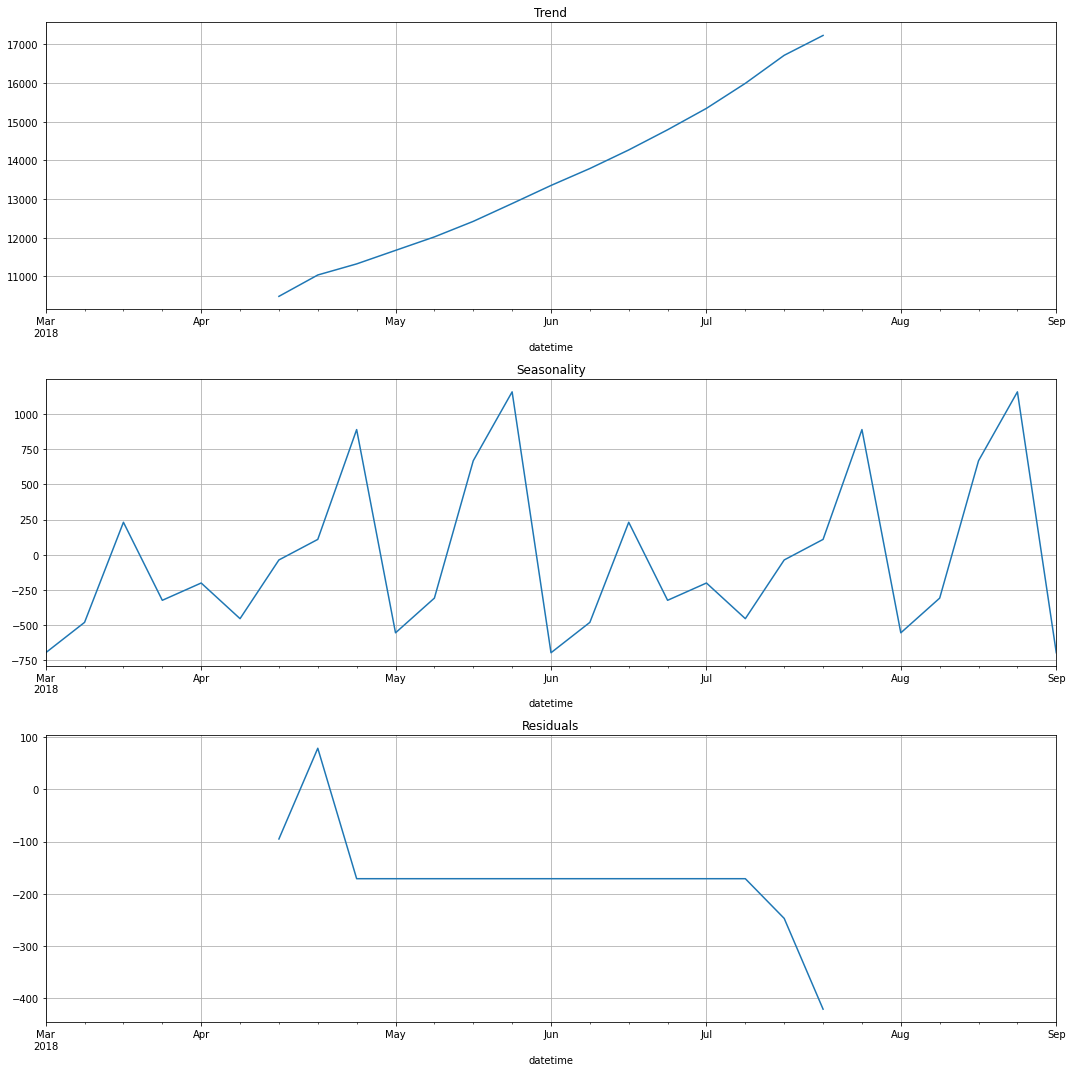

In [14]:
# декомпозицию по сезонам, трендам и остаткам по всем данным с ресемплом по 1 неделе

decomposed = seasonal_decompose(data_2_с['num_orders'], period = 13) 

plt.figure(figsize=(15,15))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.grid(True)
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.grid(True)
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.grid(True)
plt.title('Residuals')

plt.tight_layout()

**Вывод:** Недельная сезонность есть, видно что пик заказов такси в каждом месяце находитя примерное посередине каждого месяца.

Проверим гипотезу о стационарности ряда.
- Нулевая гипотеза - ряд нестационарный
- Альтернативная гипотеза - ряд стационарный

Используем пороговое значение, равное 0,05 (5%).

In [15]:
data_orig_copy = data_orig.copy()
data_orig_copy = data_orig_copy.resample('H').sum()

test_statistic, p_value, usedlag, nobs, critical_values, icbest = adfuller(data_orig_copy)
print('p-value = ' + str(p_value))


p-value = 0.028940051402612906


**Вывод:** Временной ряд нестационарен, значит в нём есть некие колебания, которые в дальнейшем могут плохо отражатся моделью.

## Обучение

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    '''Фнкция по созданию признаков модели'''
#     data['year'] = data.index.year
#     data['month'] = data.index.month
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag).fillna(0)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean().fillna(0)

In [17]:
def rsme(pred, y):
    '''Для просмотра метрика RMSE'''
    mse = mean_squared_error(y, pred)
    rmse = np.sqrt(mse)
    print('RMSE:', rmse)

In [18]:
data_for_lr_copy = data_for_lr.copy()
data_for_lr_copy = data_for_lr_copy.resample('1H').sum()

make_features(data_for_lr_copy, 35 , 48)

In [19]:
# Разделим на тренировочну, валидационную и тестовую выборку
train, test = train_test_split(data_for_lr_copy, shuffle=False, test_size=0.1)

train_y = train['num_orders']
train_X = train.drop('num_orders', axis = 1)

test_y = test['num_orders']
test_X = test.drop('num_orders', axis = 1)

In [20]:
train_X.shape, test_X.shape

((3974, 39), (442, 39))

In [21]:
%%time

# Закодируем данные

cat_cols = ['day', 'dayofweek']
num_cols = [f'lag_{x+1}' for x in range(35)]

# создаем и обучаем encoder
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(train_X[cat_cols])

# трансформируем и обучаем train
train_X[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(train_X[cat_cols])

# удаляем старые колонки
train_X = train_X.drop(cat_cols, axis=1)

# трансформируем test
test_X[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(test_X[cat_cols])

# удаляем старые колонки
test_X = test_X.drop(cat_cols, axis=1)

# скалируем числовые колонки
scaler = StandardScaler()

train_X[num_cols] = scaler.fit_transform(train_X[num_cols])
test_X[num_cols] = scaler.transform(test_X[num_cols])

CPU times: user 88.4 ms, sys: 3.26 ms, total: 91.6 ms
Wall time: 102 ms


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [22]:
%%time
'''линейная регрессия обучение'''

# модель
model_lr = LinearRegression()

# комбинаций гиперпараметров
param_grid = {
#     'fit_intercept': [False, True],
#     'copy_X': [False, True],
    'n_jobs': [-1, 0, 1, None],
    'positive': [True, False]
    }

tscv = TimeSeriesSplit(n_splits=5)

# подбор гиперпараметров
rs_lr = GridSearchCV(
    model_lr,
    param_grid = param_grid,
    scoring = "neg_root_mean_squared_error",
    n_jobs = -1,
    cv = tscv
    )

# фит модели
rs_lr.fit(train_X, train_y)

# лучшие параметры
try:
    print('fbest_params:', {rs_lr.best_params_})
except:
    print('fbest_params:', dict(rs_lr.best_params_))


fbest_params: {'n_jobs': -1, 'positive': True}
CPU times: user 4.05 s, sys: 4.42 s, total: 8.47 s
Wall time: 8.45 s


In [23]:
# Проверка метрики на трейне
rs_lr.best_estimator_.fit(train_X, train_y)
rsme(rs_lr.predict(train_X), train_y)

RMSE: 26.308516751761353


In [24]:
%%time
'''Случайный лес'''

# модель
model_rf = RandomForestRegressor(random_state = 12345)

# комбинаций гиперпараметров
param_grid = {
    'n_estimators': [10, 15],
    'criterion': ['mse', 'squared_error'],
    'max_depth': [None, 10, 100, 150],
    'bootstrap': [True, False],
    'n_jobs': [1, -1]
    }

tscv = TimeSeriesSplit(n_splits=5)

# подбор гиперпараметров
rs_rf = GridSearchCV(
    model_rf,
    param_grid = param_grid,
    scoring = "neg_root_mean_squared_error",
    n_jobs = -1,
    cv = tscv
    )

# фит модели
rs_rf.fit(train_X, train_y)

# лучшие параметры
try:
    print('fbest_params:', {rs_rf.best_params_})
except:
    print('fbest_params:', dict(rs_rf.best_params_))

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
160 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.9/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/_

fbest_params: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': None, 'n_estimators': 15, 'n_jobs': 1}
CPU times: user 1min 34s, sys: 244 ms, total: 1min 34s
Wall time: 1min 34s


In [25]:
# Проверка метрики на трейне
rs_rf.best_estimator_.fit(train_X, train_y)
rsme(rs_rf.predict(train_X), train_y)

RMSE: 9.686034834536713


In [26]:
%%time

model_CB = CatBoostRegressor()


# комбинаций гиперпараметров
param_grid = {
#     'iterations' : [None, 10, 100, 500, 1000],
#     'learning_rate': [None, 0.01, 0.02,],
    'random_state': [42]
    }

tscv = TimeSeriesSplit(n_splits=5)
# подбор гиперпараметров
rs_CB = GridSearchCV(
        model_CB,
        param_grid = param_grid,
        scoring = "neg_root_mean_squared_error",
        n_jobs = -1,
        cv = tscv,
        verbose = -1 
    )

# фит модели
rs_CB.fit(train_X, train_y)

# лучшие параметры
# try:
#     print('fbest_params:', {rs_CB.best_params_})
# except:
#     print('fbest_params:', dict(rs_CB.best_params_))

Learning rate set to 0.038378
0:	learn: 29.2570314	total: 53.2ms	remaining: 53.1s
1:	learn: 28.7734335	total: 57.6ms	remaining: 28.7s
2:	learn: 28.3421277	total: 62ms	remaining: 20.6s
3:	learn: 27.8336618	total: 66.6ms	remaining: 16.6s
4:	learn: 27.4479163	total: 70.7ms	remaining: 14.1s
5:	learn: 27.0455757	total: 75ms	remaining: 12.4s
6:	learn: 26.6942955	total: 79ms	remaining: 11.2s
7:	learn: 26.3249046	total: 83.4ms	remaining: 10.3s
8:	learn: 25.9433426	total: 87.6ms	remaining: 9.64s
9:	learn: 25.5963645	total: 91.8ms	remaining: 9.09s
10:	learn: 25.2050860	total: 95.9ms	remaining: 8.62s
11:	learn: 24.8876838	total: 100ms	remaining: 8.27s
12:	learn: 24.5945869	total: 105ms	remaining: 7.96s
13:	learn: 24.3571359	total: 109ms	remaining: 7.71s
14:	learn: 24.1209952	total: 114ms	remaining: 7.48s
15:	learn: 23.8584325	total: 118ms	remaining: 7.27s
16:	learn: 23.5341137	total: 123ms	remaining: 7.09s
17:	learn: 23.2613643	total: 127ms	remaining: 6.93s
18:	learn: 22.9768778	total: 132ms	rema

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7ff084d30910>,
             n_jobs=-1, param_grid={'random_state': [42]},
             scoring='neg_root_mean_squared_error', verbose=-1)

In [27]:
# Проверка метрики на трейне
rs_CB.best_estimator_.fit(train_X, train_y)
rsme(rs_CB.predict(train_X), train_y)

Learning rate set to 0.050916
0:	learn: 37.6741107	total: 13.1ms	remaining: 13.1s
1:	learn: 36.8057874	total: 23.5ms	remaining: 11.7s
2:	learn: 35.9182836	total: 31.8ms	remaining: 10.6s
3:	learn: 35.1470396	total: 41ms	remaining: 10.2s
4:	learn: 34.5265294	total: 52.9ms	remaining: 10.5s
5:	learn: 33.8285289	total: 65.6ms	remaining: 10.9s
6:	learn: 33.2202474	total: 79.5ms	remaining: 11.3s
7:	learn: 32.5807542	total: 93.1ms	remaining: 11.5s
8:	learn: 32.0470699	total: 106ms	remaining: 11.7s
9:	learn: 31.5249816	total: 119ms	remaining: 11.8s
10:	learn: 31.0752567	total: 132ms	remaining: 11.9s
11:	learn: 30.6051327	total: 145ms	remaining: 12s
12:	learn: 30.1686514	total: 158ms	remaining: 12s
13:	learn: 29.7771656	total: 170ms	remaining: 12s
14:	learn: 29.3352093	total: 182ms	remaining: 12s
15:	learn: 28.9528630	total: 195ms	remaining: 12s
16:	learn: 28.6088012	total: 207ms	remaining: 12s
17:	learn: 28.2801674	total: 219ms	remaining: 12s
18:	learn: 28.0229786	total: 232ms	remaining: 12s
19

In [28]:
# на последок посмотрим на результата нейросети с 1 скрытым слоекм
X_train = torch.FloatTensor(train_X.values)
y_train = torch.FloatTensor(train_y.values)

In [29]:
# базовая нейронная сеть
class LR_neuro(nn.Module):
    
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_out_neurons):
        super(LR_neuro, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_out_neurons)
        
        
    def forward(self, x):
        
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)

        return out

In [30]:
def LR_neuro_search(num_epochs, learning_rate, n_hidden_neurons_1, 
                      n_in_neurons = X_train.shape[1], n_out_neurons = 1):
    
    '''Функция для обучения и поиска лучших параметров нейросети'''
    
    torch.manual_seed(1234)
    
    model  = LR_neuro(n_in_neurons,n_hidden_neurons_1, n_out_neurons)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss = nn.MSELoss()

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        preds = model.forward(X_train).flatten()

        loss_value = loss(preds, y_train)

        loss_value.backward()

        optimizer.step()

        if epoch % 1000 == 0 or epoch == num_epochs - 1:

            print('Эпоха =',  epoch)

            model.eval()
            pred = model.forward(X_train).flatten()
            loss_value = loss(pred, y_train)

            print('RMSE = ', math.sqrt(loss_value.item()))

            print()
            
    return model

In [31]:
%%time
torch.manual_seed(1234)

n_hidden_neurons_1 = 32
num_epochs = 10000
learning_rate = 0.1

model = LR_neuro_search(num_epochs, learning_rate, n_hidden_neurons_1)

Эпоха = 0
RMSE =  70.6066416958242

Эпоха = 1000
RMSE =  18.486439451758027

Эпоха = 2000
RMSE =  17.49685553501775

Эпоха = 3000
RMSE =  16.94601575448258

Эпоха = 4000
RMSE =  16.844502787851052

Эпоха = 5000
RMSE =  16.522859401825702

Эпоха = 6000
RMSE =  16.198735995489354

Эпоха = 7000
RMSE =  16.23759104032888

Эпоха = 8000
RMSE =  16.059255546902016

Эпоха = 9000
RMSE =  16.103031304307272

Эпоха = 9999
RMSE =  15.928537519029083

CPU times: user 59.4 s, sys: 2.28 s, total: 1min 1s
Wall time: 1min 1s


**Вывод:** Лучшей моделью оказался Catboost. Неплохие показатели (Относительно переобучения) показал также линейная регрессия.

## Тестирование

In [32]:
best_CB = CatBoostRegressor(random_state = 42)
best_CB.fit(train_X, train_y)

Learning rate set to 0.050916
0:	learn: 37.6741107	total: 7.67ms	remaining: 7.66s
1:	learn: 36.8057874	total: 15.3ms	remaining: 7.62s
2:	learn: 35.9182836	total: 22.8ms	remaining: 7.58s
3:	learn: 35.1470396	total: 30.6ms	remaining: 7.63s
4:	learn: 34.5265294	total: 38.8ms	remaining: 7.73s
5:	learn: 33.8285289	total: 47.2ms	remaining: 7.82s
6:	learn: 33.2202474	total: 54.7ms	remaining: 7.76s
7:	learn: 32.5807542	total: 62.6ms	remaining: 7.76s
8:	learn: 32.0470699	total: 70.1ms	remaining: 7.71s
9:	learn: 31.5249816	total: 77.6ms	remaining: 7.68s
10:	learn: 31.0752567	total: 84.8ms	remaining: 7.62s
11:	learn: 30.6051327	total: 92.2ms	remaining: 7.59s
12:	learn: 30.1686514	total: 99.6ms	remaining: 7.56s
13:	learn: 29.7771656	total: 107ms	remaining: 7.55s
14:	learn: 29.3352093	total: 115ms	remaining: 7.54s
15:	learn: 28.9528630	total: 122ms	remaining: 7.51s
16:	learn: 28.6088012	total: 130ms	remaining: 7.52s
17:	learn: 28.2801674	total: 138ms	remaining: 7.53s
18:	learn: 28.0229786	total: 14

In [33]:
print('Обучающая выборка')
rsme(best_CB.predict(train_X), train_y)
print('Тестовая выборка')
rsme(best_CB.predict(test_X), test_y)

Обучающая выборка
RMSE: 9.959460798821196
Тестовая выборка
RMSE: 42.638664827474585


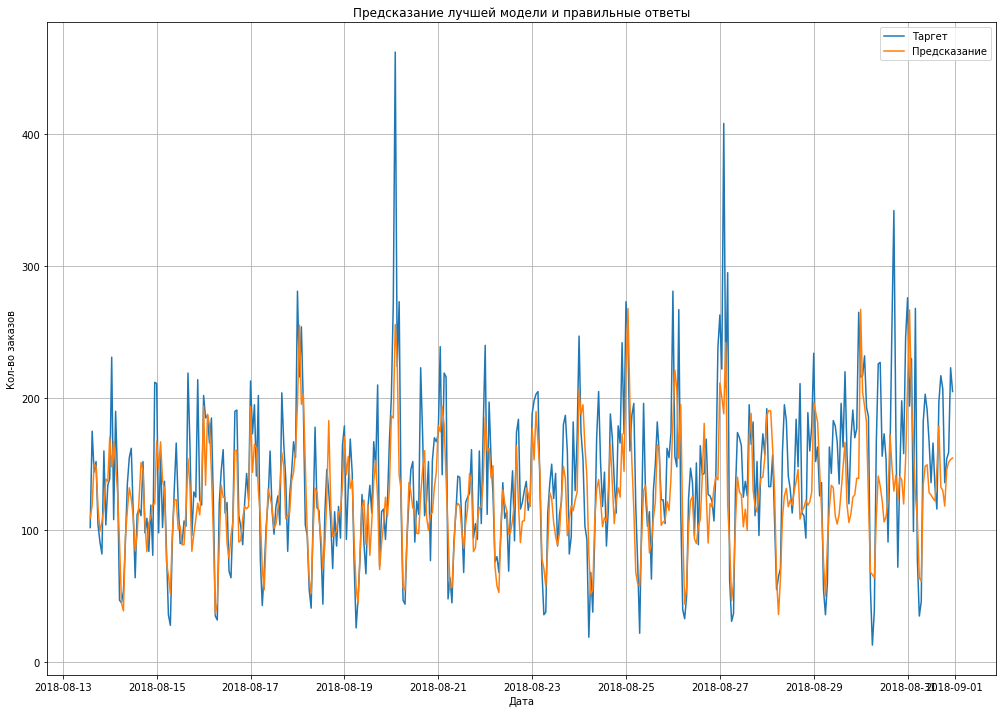

In [34]:
# Посмотрим как наша модель предсказывает значения

test['pred_orders'] = best_CB.predict(test_X)

plt.figure(figsize=(17,12))
plt.plot(test['num_orders'])
plt.plot(test['pred_orders'])
plt.grid(True)
plt.title('Предсказание лучшей модели и правильные ответы')
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.legend(['Таргет', 'Предсказание'])
plt.show()



<div style="border:solid steelgreen 4px; padding: 20px; border-radius: 15px">
<h1>Итог:</h1>

>В ходе работы были выполнены следующие операции:
>>- Исследованы временные особенности данных
>>- Подготовлены фичи для обучения моделей
>>- Выбрана лучшая модель
>>- Протестирована лучшая модель

> В ходе исследования была подобрана лучшая модель - CatBoost, метрика на тестовой выборке составила 42,63. В модели явно прослеживается сильное переобучени. Так же по графику предсказания видно, что модель обучилась не лучшим образом и "заучила" ответы.